# Customisable Prediction Accuracy

In this notebook, any specified model which adheres to the sklearn API can be fitted across expanding training windows starting in 2021, with predictions made and plotted for the week after the training window. Models are persisted to disk for quickly repeatable runs.

In [1]:
import os
from joblib import dump, load
import numpy as np
import pandas as pd
import seaborn as sns
from tscv import GapRollForward
from tqdm.notebook import tqdm

# --- notebook parameters: import, choose model, set hyperparameters
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
    AdaBoostRegressor, HistGradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor

MODEL_SELECTION = 'hgb'
MODELS_DEFINITION = {
    'rf': {
        'class': RandomForestRegressor,
        'kwargs': {
            'n_jobs': 8
        }
    },
    'gb': {
        'class': GradientBoostingRegressor,
        'kwargs': {}
    },
    'hgb': {
        'class': HistGradientBoostingRegressor,
        'kwargs': {} # capable of quantile loss, l2reg
    },
    'ada': {
        'class': AdaBoostRegressor,
        'kwargs': {}
    },
    'knn': {
        'class': KNeighborsRegressor,
        'kwargs': {}
    }
}
# --- end notebook parameters

MODEL = MODELS_DEFINITION[MODEL_SELECTION]['class']
MODEL_KWARGS = MODELS_DEFINITION[MODEL_SELECTION]['kwargs']
model_dir = f'../models/sa/{MODEL_SELECTION}'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

# import and preprocess SA data
df = pd.read_csv(os.path.relpath('../data/merged_interpolated.csv'))
df.datetime = df.datetime.astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['day_of_week'] = dt.day_of_week
df['week'] = dt.isocalendar().week
X_inds = list(range(1, 8)) + list(range(11, 18))
y_ind = 9

df_2021 = df[df['year'] >= 2021]

# specify rolling training window strategy
obs_year = 48*365
obs_week = 48*7
tscv = GapRollForward(min_train_size=obs_week, #max_train_size=obs_year,
                      min_test_size=obs_week, max_test_size=obs_week,
                      roll_size=obs_week)
print(sum(1 for i in tscv.split(df_2021)), 'models to be loaded/trained')

# load persisted models if they exist, otherwise train/persist new models and predict
prdfs = []
for i, (train_ind, test_ind) in tqdm(enumerate(tscv.split(df_2021))):
    X_train, X_test = df_2021.iloc[train_ind, X_inds], df_2021.iloc[test_ind, X_inds]
    y_train, y_test = df_2021.iloc[train_ind, y_ind], df_2021.iloc[test_ind, y_ind]

    # train or load
    begin, end = df_2021.iloc[[train_ind[0], train_ind[-1]], 0].dt.date
    argstring = '_'.join([f'{k}={v}' for k, v in MODEL_KWARGS.items()])
    model_filename = os.path.join(model_dir, f'{begin}_{end}_{argstring}.joblib')
    try:
        model = load(model_filename)
    except FileNotFoundError:
        model = MODEL(**MODEL_KWARGS)
        model.fit(X_train, y_train)
        dump(model, model_filename)
    
    # predict
    prd = model.predict(X_test)
    prdf = pd.DataFrame({'datetime': df_2021.iloc[test_ind, 0], 
                        'model': i,
                        'train_end': end,
                        'training_weeks': (end - begin).days // 7,
                        'predicted': prd,
                        'net_load': y_test})
    prdfs.append(prdf)

predictions = pd.concat(prdfs)
predictions['residual'] = predictions['predicted'] - predictions['net_load']
predictions['pe'] = predictions['residual'] / predictions['net_load']
predictions['ape'] = predictions['pe'].abs()
prediction_summary = predictions.groupby('training_weeks').describe()

print(MODEL_SELECTION, 'MAPE:', predictions['ape'].mean())

112 models to be loaded/trained


0it [00:00, ?it/s]

hgb MAPE: 0.09369210331153811


In [2]:
predictions.head()

,datetime,model,train_end,training_weeks,predicted,net_load,residual,pe,ape
49853,2021-01-08 00:00:00,0,2021-01-07,0,1453.060502,1557,-103.939498,-0.066756,0.066756
49854,2021-01-08 00:30:00,0,2021-01-07,0,1494.994270,1570,-75.005730,-0.047774,0.047774
49855,2021-01-08 01:00:00,0,2021-01-07,0,1454.056227,1527,-72.943773,-0.047769,0.047769
49856,2021-01-08 01:30:00,0,2021-01-07,0,1428.363008,1442,-13.636992,-0.009457,0.009457
49857,2021-01-08 02:00:00,0,2021-01-07,0,1270.821794,1396,-125.178206,-0.089669,0.089669


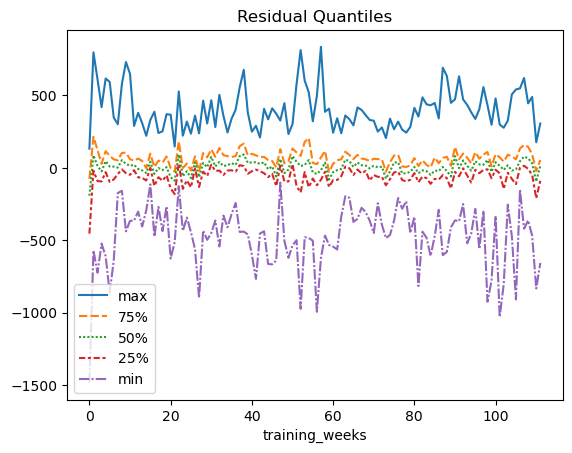

In [3]:
p = sns.lineplot(prediction_summary['residual'][['max', '75%', '50%', '25%', 'min']]).set(title='Residual Quantiles')

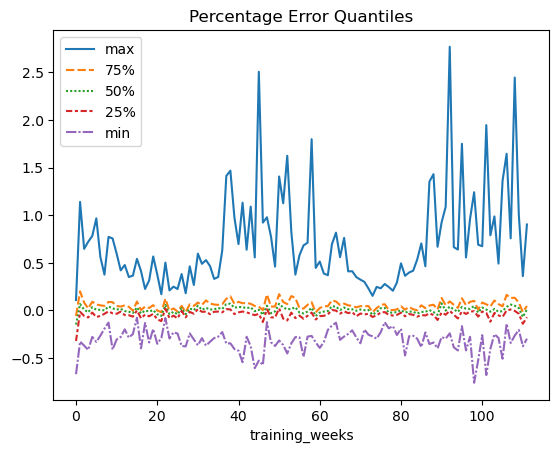

In [4]:
p = sns.lineplot(prediction_summary['pe'][['max', '75%', '50%', '25%', 'min']]).set(title='Percentage Error Quantiles')

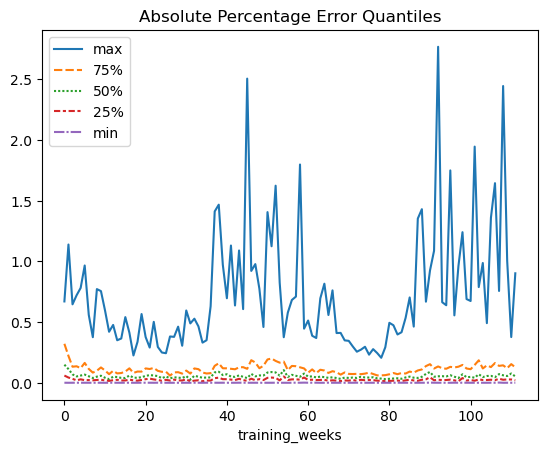

In [5]:
p = sns.lineplot(prediction_summary['ape'][['max', '75%', '50%', '25%', 'min']]).set(title='Absolute Percentage Error Quantiles')